In [1]:
from dataclasses import dataclass
import tqdm
from typing import Callable, Dict, Optional, Tuple, Union

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import Distribution as torchDist

from adaptive_mcmc.distributions.distribution import SamplableDistribution, GaussianMixture, Distribution
from adaptive_mcmc.samplers import samplers, base_sampler
from adaptive_mcmc.samplers.stopping_rule import TVStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils, Benchmark

2024-12-29 00:14:15.675048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735420455.685144    5118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735420455.688172    5118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

base_meta = {
    "sigma": 1.,
    "sigma_lr": 0.015,
    "target_acceptance": 0.574,
    "device": device,
}

meta_fisher={
    "damping": 10,
}

In [4]:
chain_count = 5
dimensions = [2, 5, 10]
gaussian_count = 5
tv_threshold = 0.05
distance_to_mass_points = 1.
sample_count = 500
sample_iter_limit = 200
burn_in_iter_count = 500
probe_period = 100
cube = 1.
tail_count_cap = 1000

stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
                       projection_count=25, tail_count_cap=tail_count_cap)
                       
algs = {
    "fisher_mala": samplers.FisherMALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=500,
        prec_burn_in_params=meta_fisher.copy(),
        prec_burn_in_iter_count=burn_in_iter_count - 500,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
    "mala": samplers.MALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=burn_in_iter_count,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
}

hist_data = {}

for dimension in tqdm.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = (
        true_covs @ true_covs.permute(0, 2, 1) + 
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(true_means, true_covs,
                         torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64))

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points,
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )
    base_meta_adj = base_meta.copy()
    base_meta_adj["sigma"] /= dimension

    for alg in algs:
        print("-" * 80)
        params.meta = base_meta_adj.copy()

        algs[alg].load_params(params)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

    
        hist_data[dimension][alg] = [algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                                     algs[alg].pipeline.sample_blocks[-1].stop_data_hist]

  0%|                                                    | 0/3 [00:00<?, ?it/s]

Processing dimension 2
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


 33%|██████████████▋                             | 1/3 [00:05<00:11,  5.67s/it]

Processing dimension 5
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


 67%|█████████████████████████████▎              | 2/3 [00:11<00:05,  5.88s/it]

Processing dimension 10
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


100%|████████████████████████████████████████████| 3/3 [00:17<00:00,  5.96s/it]


In [5]:
tv_threshold = 0.05

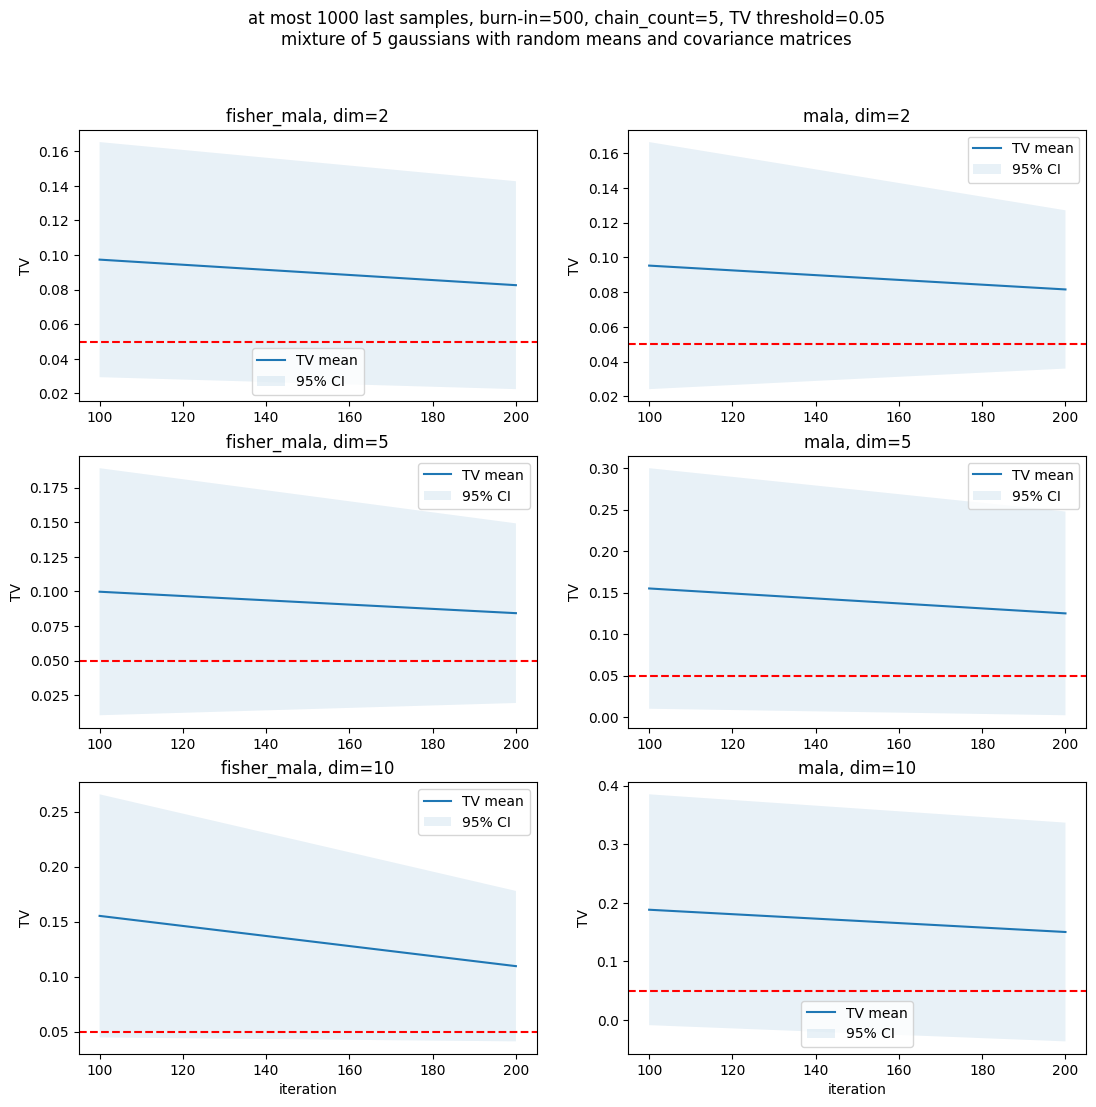

In [6]:
fig, axes = plt.subplots(nrows=len(dimensions), ncols=2, figsize=(13, 4*len(dimensions), ))
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()